In [1]:
import torch
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F # activation functions.....etc
from torch.utils.data import DataLoader # easier dataset management
import torchvision.datasets as datasets 
import torchvision.transforms as transforms 
import torchvision.models as models
import torchvision
from PIL import Image

In [2]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model=models.vgg19(pretrained=True).features

print(model)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
['0','5','10','19','28']

In [3]:
class VGG(nn.Module):
  def __init__(self):
    super(VGG,self).__init__()

    self.chosen_features=['0','5','10','19','28']
    self.model=models.vgg19(pretrained=True).features[:29]
  
  def forward(self,x):
    features=[]

    for layer_num,layer in enumerate(self.model):
      x=layer(x)

      if str(layer_num) in self.chosen_features:
        features.append(x)
      

    return features

In [4]:
image_size=356
loader=transforms.Compose(
    [
     transforms.Resize((image_size,image_size)),
     transforms.ToTensor()
    ]
)

In [5]:
def load_image(image_name):
  image=Image.open(image_name)
  image=loader(image).unsqueeze(0)  # adds a 1 dimention at the 0th position
  
  return image.to(device)

In [6]:
original_image=load_image('/content/drive/MyDrive/Pytorch Tutorial/Datasets/NST/content.jpg')
style_image=load_image('/content/drive/MyDrive/Pytorch Tutorial/Datasets/NST/style1.jpeg')
generated=original_image.clone().requires_grad_(True) #only this will get trained

In [7]:
#Hyper-Parameters

total_steps=6000
lr=0.001
alpha=1
beta=0.01
optimizer=optim.Adam([generated],lr=lr)

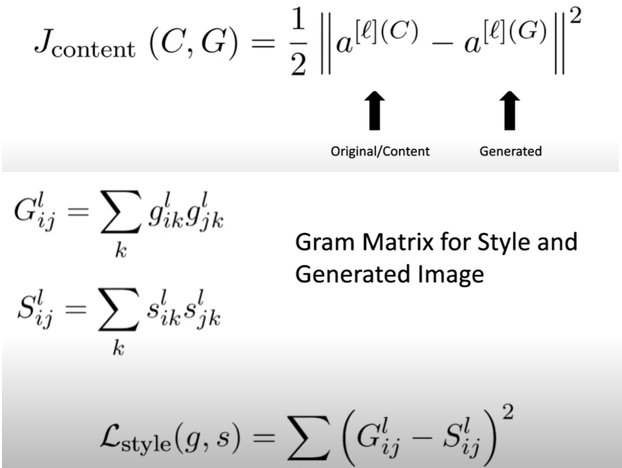

In [9]:
model=VGG().to(device).eval() # no training/ freeze
for step in range(total_steps):
  generated_features=model(generated)
  original_image_features=model(original_image)
  style_features=model(style_image)


  style_loss=original_loss=0

  for(gen_feat,org_feat,stl_feat) in zip(generated_features,original_image_features,style_features): # in each itr, one of the five conv layers for each image will pass
    batch_size,channel,height,width=gen_feat.shape # shapes will change based on which conv layer we are taking, so necessary to keep track everytime

    original_loss+=torch.mean((gen_feat-org_feat)**2) # content loss

    # compute gram matrix

    # gram mat for the generated image
    G=gen_feat.view(channel,height*width).mm(
        gen_feat.view(channel,height*width).t() # batch size=1 always 1  image is passed
    )

    #gram mat for style  image
    A=stl_feat.view(channel,height*width).mm(
        stl_feat.view(channel,height*width).t() # batch size=1 always 1  image is passed
    )

    style_loss+=torch.mean((G-A)**2)
  total_loss=alpha*original_loss + beta* style_loss

  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

  if step%200==0:
    print(total_loss)
    torchvision.utils.save_image(generated, 'output-{}.png'.format(step+1))




tensor(1186948., device='cuda:0', grad_fn=<AddBackward0>)
tensor(82100.1328, device='cuda:0', grad_fn=<AddBackward0>)
tensor(46675.4922, device='cuda:0', grad_fn=<AddBackward0>)
tensor(25598.2734, device='cuda:0', grad_fn=<AddBackward0>)
tensor(12895.5303, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7182.4536, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5053.1343, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4125.3198, device='cuda:0', grad_fn=<AddBackward0>)


KeyboardInterrupt: ignored